<a href="https://colab.research.google.com/github/kofibeans/APM1111-FA8/blob/main/Aquino_APM1111_FA8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **PlantGrowth: One-Way ANOVA**
Do a complete data analysis for PlantGrowth in {datasets} package in R using a one-way ANOVA (1B) and provide a complete report in APA style.

Null hypothesis: There is no significant difference on weight between treatment groups.

### **Import Library**
The following code is written in Python 3.x. Libraries provide pre-written functionality to perform necessary tasks.

In [188]:
# load packages

import sys # access to system parameters
print("Python version: {}". format(sys.version))

import pandas as pd # collection of functions for data processing and analysis modeled after R dataframes with SQL like features
print("pandas version: {}". format(pd.__version__))

import matplotlib # collection of functions for scientific and publication-ready visualization
print("matplotlib version: {}". format(matplotlib.__version__))

import numpy as np # foundational package for scientific computing
print("NumPy version: {}". format(np.__version__))

import scipy as sp # collection of functions for scientific computing and advanced mathematics
print("SciPy version: {}". format(sp.__version__))

import IPython
from IPython.display import HTML, display # pretty printing of dataframes in Jupyter notebook

!pip install pingouin -q -q -q
import pingouin as pg

print("IPython version: {}". format(IPython.__version__))

# data visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns

from pandas.plotting import scatter_matrix

# configure visualization defaults
#%matplotlib inline = show plots in Jupyter Notebook browser
%matplotlib inline
mpl.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

# misc libraries
import random
import time

# ignore warnings
import warnings
warnings.filterwarnings('ignore')
print('-'*25)

Python version: 3.10.12 (main, Jun 11 2023, 05:26:28) [GCC 11.4.0]
pandas version: 1.5.3
matplotlib version: 3.7.1
NumPy version: 1.23.5
SciPy version: 1.11.3
IPython version: 7.34.0
-------------------------


### **Acquire the Data**
The Python Pandas package facilitates working with datasets. Acquiring the training and testing datasets into Pandas DataFrames is the initial step, followed by combining these datasets to perform operations on both simultaneously.

In [189]:
# import data
url = 'https://raw.githubusercontent.com/kofibeans/APM1111-FA8/main/plant_growth.csv'

# load the url into pd read_csv() to get the dataframe
df = pd.read_csv(url)

# display the dataframe
df.style

,weight,group
0,4.170000,ctrl
1,5.580000,ctrl
2,5.180000,ctrl
3,6.110000,ctrl
4,4.500000,ctrl
5,4.610000,ctrl
6,5.170000,ctrl
7,4.530000,ctrl
8,5.330000,ctrl
9,5.140000,ctrl


### **Check Assumptions**
The assumptions based on the data analysis done so far need to be validated further before taking appropriate actions.

**Assumption 1:** You have one dependent variable that is measured at the continuous level.

> ***Remark.*** The dependent variable was called `weight` and is a continuous level.

**Assumption 2:** You have one independent variable that consists of two categorical, independent
groups.

> ***Remark.*** The independent variable is the `plant condition` which is categorized into independent groups: two distinct treatment conditions and a control condition.

**Assumption 3:** You should have independence of observations.

> ***Remark.*** Each observation is independent with each other as there is no relationship between the observations in each group of the independent variable or between the groups themselves.

**Assumption 4:** There should be no significant outliers in the three or more groups of your independent variable in terms of the dependent variable.

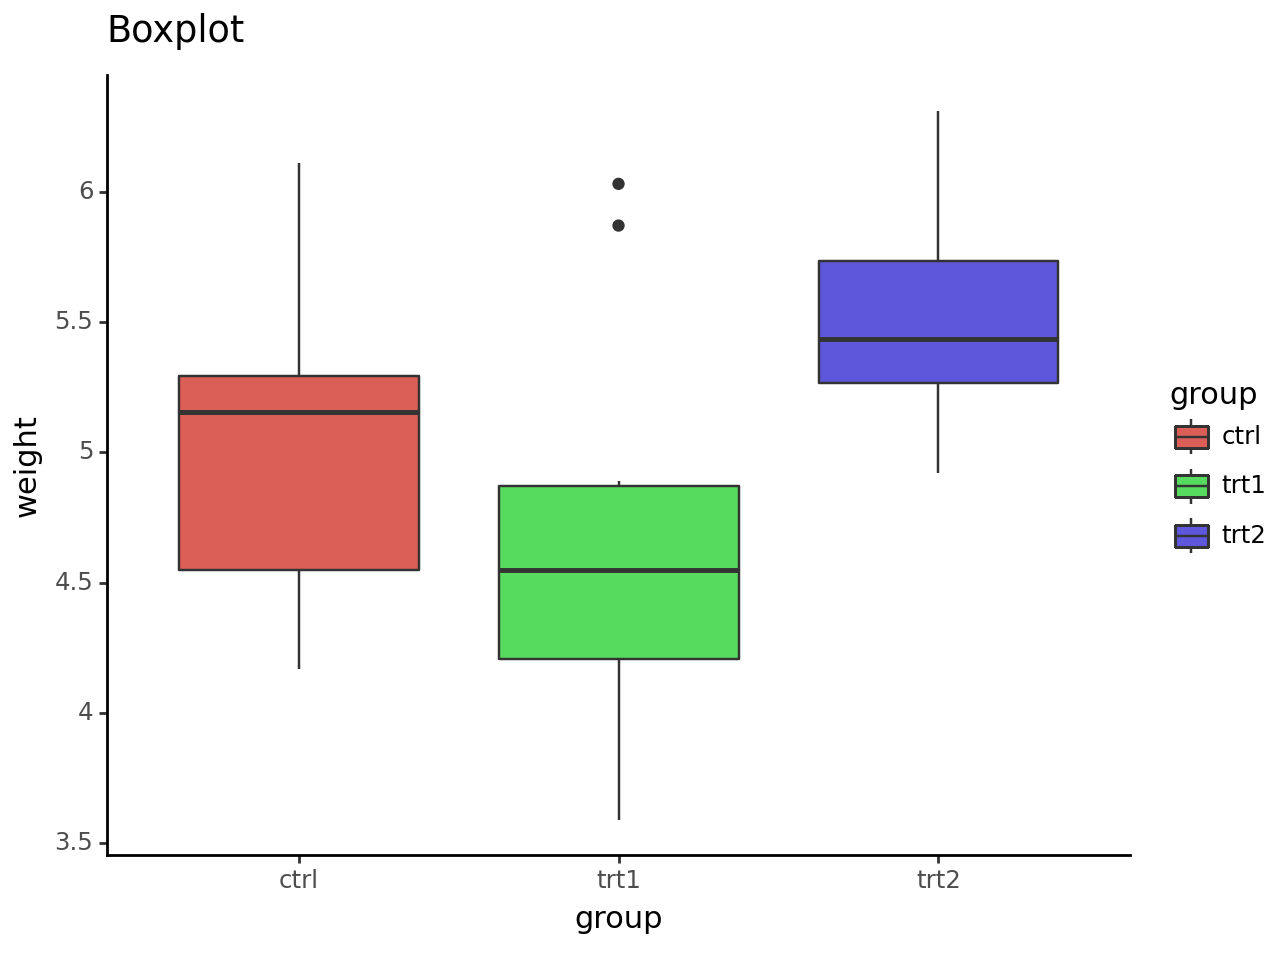

<Figure Size: (640 x 480)>

In [190]:
from plotnine import ggplot, aes, geom_boxplot, labs, theme_classic

(
  ggplot(df)
  + aes(x = "group", y="weight", fill = "group")
  + geom_boxplot()
  + labs(title = "Boxplot")
  + theme_classic()
)


> ***Remark.*** There were no significant outliers in the treatment/condition groups in terms of the weight, as assessed by visual inspection of boxplots.

**Finding the Outlier using z-score.**

To identify outliers using the z-score, we can set a threshold value by 1.5 or 3. Data points with a z-score greater than 1.5 or less than -1.5 can be considered an outlier. Whereas any data point with a z-score greater than 3 or less than -3 can be considered an *extreme* outlier.

In [191]:
# calculate z-scores for each group
df['z_score'] = df.groupby('group')['weight'].transform(lambda x: (x - x.mean()) / x.std())

# identify outliers based on z-score threshold
outliers = df[abs(df['z_score']) > 1.5]

# identify outliers based on z-score threshold
e_outliers = df[abs(df['z_score']) > 3]

# display the outliers
print("The following data points are considered as outliers:")
print(outliers)

print("\nThe following data points are considered as extreme outliers:")
print(e_outliers)

The following data points are considered as outliers:
    weight group   z_score
3     6.11  ctrl  1.848767
14    5.87  trt1  1.523292
16    6.03  trt1  1.724886
20    6.31  trt2  1.771458

The following data points are considered as extreme outliers:
Empty DataFrame
Columns: [weight, group, z_score]
Index: []



> ***Remark.*** There were no extreme outliers.

**Assumption 5:** Your dependent variable should be approximately normally distributed for each group of the independent variable.

In [192]:
df.groupby('group')['weight'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
ctrl,10.0,5.032,0.583091,4.17,4.5500,5.155,5.2925,6.11
trt1,10.0,4.661,0.793676,3.59,4.2075,4.550,4.8700,6.03
trt2,10.0,5.526,0.442573,4.92,5.2675,5.435,5.7350,6.31


In [193]:
import scipy.stats as stats

# checking the normality assumption for each group using Shapiro-Wilk test
group_0 = df[df['group'] == 'ctrl']['weight']
group_1 = df[df['group'] == 'trt1']['weight']
group_2 = df[df['group'] == 'trt2']['weight']

shapiro_0 = stats.shapiro(group_0)
shapiro_1 = stats.shapiro(group_1)
shapiro_2 = stats.shapiro(group_2)

# creating a table for the Shapiro-Wilk test results
results = pd.DataFrame({'Group': ['Control', 'Treatment 1', 'Treatment_2'],
                        'W-statistic': [shapiro_0.statistic, shapiro_1.statistic, shapiro_2.statistic],
                       'p-value': [shapiro_0.pvalue, shapiro_1.pvalue, shapiro_2.pvalue]})

print("\nTest of Normality (Shapiro-Wilk)")
results.style


Test of Normality (Shapiro-Wilk)


,Group,W-statistic,p-value
0,Control,0.956682,0.747474
1,Treatment 1,0.930411,0.451946
2,Treatment_2,0.941005,0.564253



> ***Remark.*** The weight is approximately normally distributed for each of the treatment groups, as assessed by Shapiro-Wilk’s test, p > 0.05.

**Assumption 6:** You have homogeneity of variances (i.e., the variance of the dependent variable is equal in each group of your independent variable).

In [194]:
# perform brown-forsythe test
bf_results = stats.levene(group_0, group_1, group_2, center='median')

# create a dictionary with the results
results = {
    'F': bf_results.statistic,
    'df1': [3 - 1],
    'df2': [len(group_0) + len(group_1) + len(group_2) - 2],
    'p': bf_results.pvalue
}

# create a dataframe with the results
results_f = pd.DataFrame(results)

# print and style the dataframe
print("\n Test of Equality of Variances (Brown-Forsythe)")
results_f.style.format("{:,.2f}")


 Test of Equality of Variances (Brown-Forsythe)


,F,df1,df2,p
0,1.12,2.00,28.00,0.34


> ***Remark.*** There was homogeneity of variances of the dependent variable for all treatment groups, as assessed by Levene’s test of homogeneity of variances, p = 0.34.

### **Computation**
A significant one-way ANOVA is generally followed up by Tukey post-hoc tests to perform multiple pairwise comparisons between groups.

In [195]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['p_eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])

    cols = ['sum_sq', 'df', 'mean_sq', 'F', 'PR(>F)', 'p_eta_sq']
    aov = aov[cols]
    return aov

model = ols('weight ~ group', data = df).fit()
aov_table = sm.stats.anova_lm(model, typ = 2)
print("\n ANOVA")
anova_table(aov_table)


 ANOVA


,sum_sq,df,mean_sq,F,PR(>F),p_eta_sq
group,3.76634,2.0,1.883170,4.846088,0.01591,0.264148
Residual,10.49209,27.0,0.388596,NaN,NaN,NaN


In [196]:
# checking the descriptive for each group using Shapiro-Wilk test
group_0 = df[df['group'] == 'ctrl']['weight']
group_1 = df[df['group'] == 'trt1']['weight']
group_2 = df[df['group'] == 'trt2']['weight']

# create a new dataframe
new_df = pd.DataFrame({'Control': group_0, 'Treatment 1': group_1, 'Treatment 2': group_2})

# use describe() on the new dataframe
results = new_df.describe().loc[['count','mean', 'std']]

print("\n Descriptives")
results.style.format("{:,.2f}")


 Descriptives


,Control,Treatment 1,Treatment 2
count,10.00,10.00,10.00
mean,5.03,4.66,5.53
std,0.58,0.79,0.44


In [197]:
import statsmodels.stats.multicomp as smm

one_tukey_smm = smm.pairwise_tukeyhsd(endog=df['weight'],groups=df['group'])

print(one_tukey_smm)

Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  ctrl   trt1   -0.371 0.3909 -1.0622 0.3202  False
  ctrl   trt2    0.494  0.198 -0.1972 1.1852  False
  trt1   trt2    0.865  0.012  0.1738 1.5562   True
---------------------------------------------------


### **Reporting**



A one-way ANOVA was conducted to evaluate if the plant growth was different for groups with different treatments. Plants were classified into three groups: control (n = 10), treatment 1 (n = 10),and treatment 2 (n = 10). There were no outliers, as assessed by visual inspection of boxplot; data was normally distributed for each group, as assessed by Shapiro-Wilk test (p > .05); and there was homogeneity of variances, as assessed by Levene's test of homogeneity of variances (p = .34). Data is presented as mean ± standard deviation. Plant growth was statistically significantly different between between different treatment groups, F(2, 27) = 4.85, p = 0.016, η²p
= 0.26. Plant growth decreased in trt1 group (M = 4.66, SD = 0.79) compared to ctr group (M = 5.03 +/- 0.58). It increased in trt2 group (M = 5.53, SD = 0.44) compared to trt1 and ctr group. Tukey post-hoc analyses revealed that the increase from trt1 to trt2 (0.87, 95% CI(0.17 to 1.56)) was statistically significant (p = 0.012), but no other group differences were statistically significant.